<a href="https://colab.research.google.com/github/sebastiancikovsky/interference-demo/blob/main/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'interference-demo'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 85.87 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/interference-demo/interference-demo/interference-demo
Detected anomalies (threshold-based): 26

Classification report (latent-space logistic regression):

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1000
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050



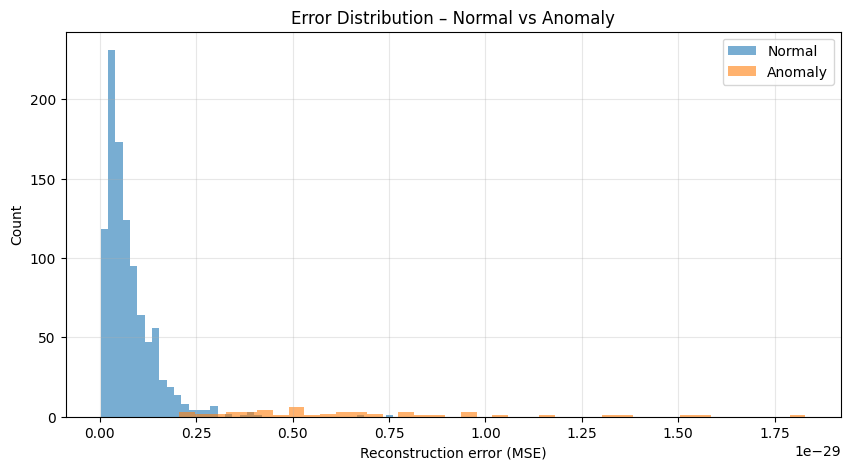

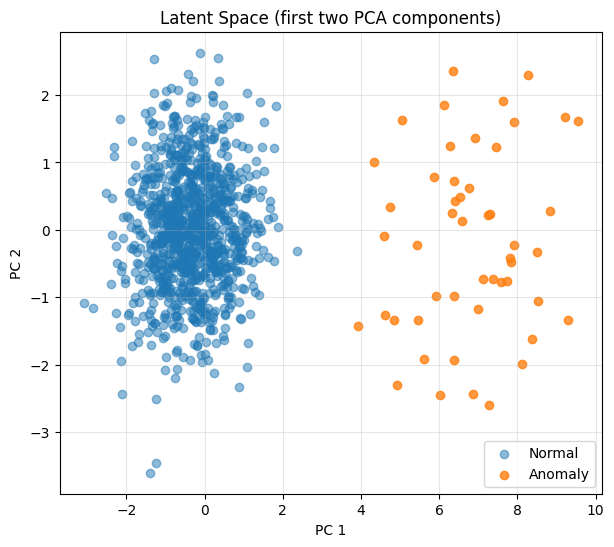

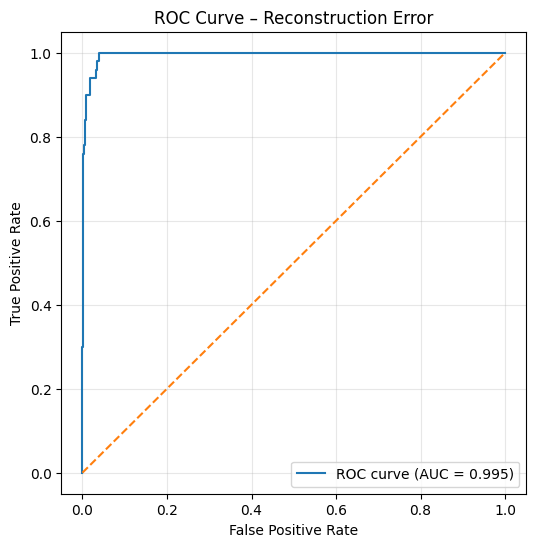

In [4]:


# 1) Clean clone & install
!rm -rf interference-demo
!git clone https://github.com/sebastiancikovsky/interference-demo.git
%cd interference-demo
!pip install -r requirements.txt

# 2) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

from pca_pipeline_demo import PCAPipeline
from anomaly_detection_demo import SimpleAnomalyDetector

# 3) Load data
df = pd.read_csv("sample_data.csv")
X = df.drop("label", axis=1).values
y = df["label"].values

# 4) PCA + reconstruction error
pca = PCAPipeline()
pca.fit(X)
Z = pca.transform(X)
errors = pca.reconstruction_error(X)

# 5) Threshold-based detector + logistic regression
detector = SimpleAnomalyDetector(threshold_std=3.0)
detector.fit(errors)
pred_flags = detector.predict(errors)

clf = LogisticRegression(max_iter=1000)
clf.fit(Z, y)
y_pred = clf.predict(Z)

print("Detected anomalies (threshold-based):", int(pred_flags.sum()))
print("\nClassification report (latent-space logistic regression):\n")
print(classification_report(y, y_pred))

# 6) Histogram reconstruction error
plt.figure(figsize=(10,5))
plt.hist(errors[y == 0], bins=40, alpha=0.6, label="Normal")
plt.hist(errors[y == 1], bins=40, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Count")
plt.title("Error Distribution – Normal vs Anomaly")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 7) Latent space scatter (first 2 PCs)
if Z.shape[1] >= 2:
    plt.figure(figsize=(7,6))
    plt.scatter(Z[y == 0, 0], Z[y == 0, 1], alpha=0.5, label="Normal")
    plt.scatter(Z[y == 1, 0], Z[y == 1, 1], alpha=0.8, label="Anomaly")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Latent Space (first two PCA components)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Not enough PCA components for scatter plot.")

# 8) ROC curve for reconstruction error
fpr, tpr, _ = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Reconstruction Error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
